In [ ]:
!pip install torch torchvision
!pip install ultralytics
!pip install diffusers

In [ ]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from ultralytics import YOLO
import os
from torch.utils.data import Dataset, DataLoader
import glob
from torch.utils.data._utils.collate import default_collate
import torch.multiprocessing as mp
import torch.cuda
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

In [ ]:
yolo_model = None
def init_yolo():
    global yolo_model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    yolo_model = YOLO('yolov8x.pt')
    yolo_model.to(device)
    return yolo_model

In [ ]:
def extract_objects(image):
    global yolo_model
    if yolo_model is None:
        init_yolo()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image = image.convert("RGB") if isinstance(image, Image.Image) else Image.open(image).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_np = np.array(image)

    with torch.no_grad():
        results = yolo_model(image_tensor, verbose=False)

    objects = []

    for det in results[0].boxes.data.cpu().numpy():
        x1, y1, x2, y2, conf, cls = det
        if conf < 0.3:
            continue

        obj_region = image_np[int(y1):int(y2), int(x1):int(x2)]
        gray = cv2.cvtColor(obj_region, cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            if len(largest_contour) >= 5:
                ellipse = cv2.fitEllipse(largest_contour)
                angle = ellipse[2]
            else:
                rect = cv2.minAreaRect(largest_contour)
                angle = rect[2]
        else:
            angle = 0

        angle = angle % 180
        if angle > 90:
            angle -= 180

        obj = {
            'bbox': [int(x1), int(y1), int(x2), int(y2)],
            'width': int(x2 - x1),
            'height': int(y2 - y1),
            'center': [(x1 + x2)/2, (y1 + y2)/2],
            'area': (x2 - x1) * (y2 - y1),
            'image': obj_region,
            'class': int(cls),
            'angle': angle
        }
        objects.append(obj)

    return objects

def rotate_image(image, angle, center=None):
    if center is None:
        center = (image.shape[1] // 2, image.shape[0] // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]),
                            flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(255, 255, 255))
    return rotated

In [ ]:
class KnollingDataset(Dataset):
    def __init__(self, messy_images, tidy_images):
        self.messy_images = messy_images
        self.tidy_images = tidy_images

    def __len__(self):
        return len(self.messy_images)

    def __getitem__(self, idx):
        messy_img = self.messy_images[idx]
        tidy_img = self.tidy_images[idx]

        if isinstance(messy_img, Image.Image):
            messy_img = messy_img.convert('RGB')
        if isinstance(tidy_img, Image.Image):
            tidy_img = tidy_img.convert('RGB')

        messy_objects = extract_objects(messy_img)
        tidy_objects = extract_objects(tidy_img)

        pos_map = torch.zeros((1, 128, 128))
        cls_map = torch.zeros((80, 128, 128))
        rot_map = torch.zeros((1, 128, 128))

        for obj in messy_objects:
            x1, y1, x2, y2 = obj['bbox']
            x1, x2 = max(0, min(x1, 128)), max(0, min(x2, 128))
            y1, y2 = max(0, min(y1, 128)), max(0, min(y2, 128))
            if x2 > x1 and y2 > y1:
                pos_map[0, y1:y2, x1:x2] = 1
                cls_map[obj['class'], y1:y2, x1:x2] = 1
                rot_map[0, y1:y2, x1:x2] = obj['angle'] / 180.0

        target_pos_map = torch.zeros((1, 128, 128))
        target_rot_map = torch.zeros((1, 128, 128))

        for obj in tidy_objects:
            x1, y1, x2, y2 = obj['bbox']
            x1, x2 = max(0, min(x1, 128)), max(0, min(x2, 128))
            y1, y2 = max(0, min(y1, 128)), max(0, min(y2, 128))
            if x2 > x1 and y2 > y1:
                target_pos_map[0, y1:y2, x1:x2] = 1
                target_rot_map[0, y1:y2, x1:x2] = obj['angle'] / 180.0

        return {
            'position': pos_map,
            'classes': cls_map,
            'rotation': rot_map,
            'target_position': target_pos_map,
            'target_rotation': target_rot_map,
            'messy_objects': messy_objects,
            'tidy_objects': tidy_objects
        }

In [ ]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_embed = nn.Sequential(
            nn.Linear(1, 128),
            nn.GELU(),
            nn.Linear(128, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
        )

        self.encoder = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(82, 128, 3, padding=1),
                nn.GroupNorm(8, 128),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.Conv2d(256, 256, 3, padding=1),
                nn.GroupNorm(8, 256),
                nn.GELU(),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.GroupNorm(8, 256),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.Conv2d(256, 256, 3, padding=1, stride=2),
                nn.GroupNorm(8, 256),
                nn.GELU(),
                nn.Conv2d(256, 256, 3, padding=1),
                nn.GroupNorm(8, 256),
                nn.GELU(),
            )
        ])

        self.attention = nn.MultiheadAttention(256, 8, batch_first=True)
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
                nn.GroupNorm(8, 256),
                nn.GELU(),
            ),
            nn.Sequential(
                nn.Conv2d(512, 256, 3, padding=1),
                nn.GroupNorm(8, 256),
                nn.GELU(),
                nn.Conv2d(256, 128, 3, padding=1),
                nn.GroupNorm(8, 128),
                nn.GELU(),
            ),
        ])

        self.position_head = nn.Sequential(
            nn.Conv2d(256, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid(),
        )

        self.rotation_head = nn.Sequential(
            nn.Conv2d(256, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.GELU(),
            nn.Conv2d(64, 1, 1),
            nn.Tanh(),
        )

    def forward(self, x, t):
        batch_size = x.shape[0]

        t = t.view(batch_size, 1)
        t_embed = self.time_embed(t)
        t_embed = t_embed.view(batch_size, -1, 1, 1).expand(-1, -1, x.shape[2], x.shape[3])

        skip_connections = []

        x = self.encoder[0](x)
        skip_connections.append(x)

        x = torch.cat([x, t_embed], dim=1)

        x = self.encoder[1](x)
        skip_connections.append(x)
        x = self.encoder[2](x)

        b, c, h, w = x.shape
        x_flat = x.flatten(2).permute(0, 2, 1)
        x_flat, _ = self.attention(x_flat, x_flat, x_flat)
        x = x_flat.permute(0, 2, 1).view(b, c, h, w)

        x = self.decoder[0](x)
        x = torch.cat([x, skip_connections.pop()], dim=1)

        x = self.decoder[1](x)
        x = torch.cat([x, skip_connections.pop()], dim=1)

        position = self.position_head(x)
        rotation = self.rotation_head(x)

        return position, rotation

In [ ]:
def edge_detection_loss(pred, target):
    def sobel(x):
        kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], device=x.device).float()
        kernel_y = kernel_x.t()
        kernel_x = kernel_x.view(1, 1, 3, 3).repeat(1, 1, 1, 1)
        kernel_y = kernel_y.view(1, 1, 3, 3).repeat(1, 1, 1, 1)

        grad_x = F.conv2d(x, kernel_x, padding=1)
        grad_y = F.conv2d(x, kernel_y, padding=1)

        return torch.sqrt(grad_x**2 + grad_y**2 + 1e-6)

    pred_edges = sobel(pred)
    target_edges = sobel(target)

    return F.mse_loss(pred_edges, target_edges)

def relative_position_loss(pred, target):
    def get_centroids(x):
        b, c, h, w = x.shape
        y_coords = torch.arange(h, device=x.device).float().view(1, 1, -1, 1)
        x_coords = torch.arange(w, device=x.device).float().view(1, 1, 1, -1)

        y_centroid = torch.sum(y_coords * x, dim=(2, 3)) / (torch.sum(x, dim=(2, 3)) + 1e-6)
        x_centroid = torch.sum(x_coords * x, dim=(2, 3)) / (torch.sum(x, dim=(2, 3)) + 1e-6)

        return y_centroid, x_centroid

    pred_y, pred_x = get_centroids(pred)
    target_y, target_x = get_centroids(target)

    return F.mse_loss(pred_y, target_y) + F.mse_loss(pred_x, target_x)

def custom_collate(batch):
    elem = batch[0]
    collated = {}

    for key in ['position', 'classes', 'rotation', 'target_position', 'target_rotation']:
        if key in elem:
            collated[key] = default_collate([d[key] for d in batch])

    collated['messy_objects'] = [d['messy_objects'] for d in batch]
    collated['tidy_objects'] = [d['tidy_objects'] for d in batch]

    return collated

def spatial_consistency_loss(pred, target, messy_objects):
    device = pred.device
    batch_size = pred.shape[0]
    total_loss = torch.tensor(0., device=device, requires_grad=True)

    for b in range(batch_size):
        if len(messy_objects[b]) < 2:
            continue

        centers_pred = []
        centers_target = []

        pred_map = pred[b, 0].detach().cpu().numpy()
        target_map = target[b, 0].detach().cpu().numpy()

        num_labels_pred, labels_pred = cv2.connectedComponents((pred_map > 0.5).astype(np.uint8))
        num_labels_target, labels_target = cv2.connectedComponents((target_map > 0.5).astype(np.uint8))

        for i in range(1, num_labels_pred):
            mask = labels_pred == i
            if np.sum(mask) > 0:
                y, x = np.where(mask)
                centers_pred.append([np.mean(x), np.mean(y)])

        for i in range(1, num_labels_target):
            mask = labels_target == i
            if np.sum(mask) > 0:
                y, x = np.where(mask)
                centers_target.append([np.mean(x), np.mean(y)])

        if len(centers_pred) < 2 or len(centers_target) < 2:
            continue

        centers_pred = torch.tensor(centers_pred, device=device, requires_grad=True)
        centers_target = torch.tensor(centers_target, device=device)

        min_centers = min(len(centers_pred), len(centers_target))
        centers_pred = centers_pred[:min_centers]
        centers_target = centers_target[:min_centers]

        dist_pred = torch.cdist(centers_pred, centers_pred)
        dist_target = torch.cdist(centers_target, centers_target)

        dist_pred = dist_pred / (torch.max(dist_pred) + 1e-6)
        dist_target = dist_target / (torch.max(dist_target) + 1e-6)

        total_loss = total_loss + F.mse_loss(dist_pred, dist_target)

    return total_loss / max(batch_size, 1)

def alignment_loss(pred):
    device = pred.device
    batch_size = pred.shape[0]
    total_loss = torch.tensor(0., device=device, requires_grad=True)

    for b in range(batch_size):
        pred_map = pred[b, 0]

        grad_y = pred_map[1:, :] - pred_map[:-1, :]
        grad_x = pred_map[:, 1:] - pred_map[:, :-1]

        grad_y_var = torch.var(grad_y[grad_y != 0]) if torch.any(grad_y != 0) else torch.tensor(0., device=device, requires_grad=True)
        grad_x_var = torch.var(grad_x[grad_x != 0]) if torch.any(grad_x != 0) else torch.tensor(0., device=device, requires_grad=True)

        total_loss = total_loss + grad_y_var + grad_x_var

    return total_loss / max(batch_size, 1)

def train_model(model, dataset, num_epochs=10, batch_size=4):
    try:
        mp.set_start_method('spawn')
    except RuntimeError:
        pass

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=5e-5,
        weight_decay=0.001,
        betas=(0.9, 0.999)
    )

    steps_per_epoch = len(DataLoader(dataset, batch_size=batch_size))

    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-4,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        div_factor=25.0,
        final_div_factor=1000.0
    )

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=custom_collate,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Training on device: {device}")
    print(f"Number of batches: {len(dataloader)}")

    best_loss = float('inf')
    best_model_state = None
    patience = 5
    patience_counter = 0

    moving_avg_loss = None
    alpha = 0.9

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        epoch_losses = {'mse_pos': 0, 'mse_rot': 0, 'edge': 0, 'spatial': 0, 'align': 0}
        num_batches = 0

        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()

            x = torch.cat([batch['position'], batch['classes'], batch['rotation']], dim=1).to(device)
            target_pos = batch['target_position'].to(device)
            target_rot = batch['target_rotation'].to(device)

            noise_scale = max(0.05, 0.5 * (1.0 - (epoch / num_epochs)))
            t = torch.rand(x.shape[0], device=device) * noise_scale
            noise = torch.randn_like(x) * 0.1
            noised_x = x + noise * t.view(-1, 1, 1, 1)
            pred_pos, pred_rot = model(noised_x, t)

            if i == 0 and epoch == 0:
                print(f"Input shape: {x.shape}")
                print(f"Predicted position shape: {pred_pos.shape}")
                print(f"Predicted rotation shape: {pred_rot.shape}")
                print(f"Target position shape: {target_pos.shape}")
                print(f"Target rotation shape: {target_rot.shape}")

            mse_loss_pos = nn.MSELoss()(pred_pos, target_pos)
            mse_loss_rot = nn.MSELoss()(pred_rot, target_rot)
            edge_loss = edge_detection_loss(pred_pos, target_pos)
            spatial_loss = spatial_consistency_loss(pred_pos, target_pos, batch['messy_objects'])
            align_loss = alignment_loss(pred_pos)

            normalized_edge_loss = edge_loss / (edge_loss.detach() + 1e-8)
            normalized_spatial_loss = spatial_loss / (spatial_loss.detach() + 1e-8)
            normalized_align_loss = align_loss / (align_loss.detach() + 1e-8)

            loss = (
                mse_loss_pos +
                0.5 * mse_loss_rot +
                0.05 * normalized_edge_loss +
                0.1 * normalized_spatial_loss +
                0.05 * normalized_align_loss
            )

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

            optimizer.step()
            scheduler.step()

            current_loss = loss.item()
            if moving_avg_loss is None:
                moving_avg_loss = current_loss
            else:
                moving_avg_loss = alpha * moving_avg_loss + (1 - alpha) * current_loss

            total_loss += current_loss
            epoch_losses['mse_pos'] += mse_loss_pos.item()
            epoch_losses['mse_rot'] += mse_loss_rot.item()
            epoch_losses['edge'] += edge_loss.item()
            epoch_losses['spatial'] += spatial_loss.item()
            epoch_losses['align'] += align_loss.item()
            num_batches += 1

            if i % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {i}, Loss: {current_loss:.4f}, MovingAvg: {moving_avg_loss:.4f}')
                print(f'MSE Pos: {mse_loss_pos.item():.4f}, MSE Rot: {mse_loss_rot.item():.4f},')
                print(f'Edge: {edge_loss.item():.4f}, Spatial: {spatial_loss.item():.4f}, Align: {align_loss.item():.4f}')
                print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')

        avg_loss = total_loss / num_batches
        avg_losses = {k: v / num_batches for k, v in epoch_losses.items()}

        print(f'Epoch {epoch+1}:')
        print(f'  Average Loss: {avg_loss:.4f}')
        print(f'  MSE Pos: {avg_losses["mse_pos"]:.4f}, MSE Rot: {avg_losses["mse_rot"]:.4f}')
        print(f'  Edge: {avg_losses["edge"]:.4f}')
        print(f'  Spatial: {avg_losses["spatial"]:.4f}')
        print(f'  Align: {avg_losses["align"]:.4f}')
        print(f'  LR: {scheduler.get_last_lr()[0]:.6f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f'New best model saved with loss: {best_loss:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break

        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_loss': best_loss,
                'moving_avg_loss': moving_avg_loss,
            }, f'knolling_model_epoch_{epoch+1}.pth')

    model.load_state_dict(best_model_state)
    return model

In [ ]:
def generate_tidy_layout(model, messy_image):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    if isinstance(messy_image, Image.Image):
        messy_array = np.array(messy_image)
    else:
        messy_array = messy_image

    background = messy_array.copy()

    objects = extract_objects(messy_image)

    if not objects:
        return Image.fromarray(messy_array)

    object_mask = np.zeros((128, 128), dtype=np.uint8)
    for obj in objects:
        x1, y1, x2, y2 = obj['bbox']
        x1, x2 = max(0, min(x1, 128)), max(0, min(x2, 128))
        y1, y2 = max(0, min(y1, 128)), max(0, min(y2, 128))
        if x2 > x1 and y2 > y1:
            object_mask[y1:y2, x1:x2] = 1

    background_pixels = messy_array[object_mask == 0]
    if len(background_pixels) > 0:
        background_color = np.median(background_pixels, axis=0)
    else:
        background_color = np.mean(messy_array.reshape(-1, 3), axis=0)

    output = np.full((128, 128, 3), background_color, dtype=np.uint8)

    pos_map = torch.zeros((1, 1, 128, 128))
    cls_map = torch.zeros((1, 80, 128, 128))
    rot_map = torch.zeros((1, 1, 128, 128))

    for obj in objects:
        x1, y1, x2, y2 = obj['bbox']
        x1, x2 = max(0, min(x1, 128)), max(0, min(x2, 128))
        y1, y2 = max(0, min(y1, 128)), max(0, min(y2, 128))
        if x2 > x1 and y2 > y1:
            pos_map[0, 0, y1:y2, x1:x2] = 1
            cls_map[0, obj['class'], y1:y2, x1:x2] = 1
            rot_map[0, 0, y1:y2, x1:x2] = obj['angle'] / 180.0

    x = torch.cat([pos_map, cls_map, rot_map], dim=1).to(device)

    with torch.no_grad():
        t = torch.zeros(1, device=device)
        pred_pos, pred_rot = model(x, t)

    pred_pos = pred_pos.cpu().numpy()[0, 0]
    pred_rot = pred_rot.cpu().numpy()[0, 0] * 180.0

    grid_size = int(np.sqrt(len(objects))) + 1
    cell_size = 128 // grid_size

    available_cells = [(i, j) for i in range(grid_size) for j in range(grid_size)]

    objects.sort(key=lambda obj: obj['width'] * obj['height'], reverse=True)

    new_objects = []

    for obj in objects:
        if not available_cells:
            break

        best_cell = available_cells[0]
        min_overlap = float('inf')

        for cell in available_cells:
            cell_x = cell[1] * cell_size
            cell_y = cell[0] * cell_size

            overlap = 0
            for placed_obj in new_objects:
                x1, y1, x2, y2 = placed_obj['bbox']
                if (cell_x < x2 and cell_x + obj['width'] > x1 and
                    cell_y < y2 and cell_y + obj['height'] > y1):
                    overlap += 1

            if overlap < min_overlap:
                min_overlap = overlap
                best_cell = cell

        cell_x = best_cell[1] * cell_size
        cell_y = best_cell[0] * cell_size

        obj_width = min(obj['width'], cell_size)
        obj_height = min(obj['height'], cell_size)

        target_angle = pred_rot[cell_y:cell_y+obj_height, cell_x:cell_x+obj_width].mean()

        new_obj = obj.copy()
        new_obj['bbox'] = [
            cell_x,
            cell_y,
            min(cell_x + obj_width, 128),
            min(cell_y + obj_height, 128)
        ]
        new_obj['target_angle'] = target_angle
        new_objects.append(new_obj)

        available_cells.remove(best_cell)

    for obj in new_objects:
        x1, y1, x2, y2 = obj['bbox']
        angle = obj['target_angle']
        rotated_img = rotate_image(obj['image'], angle, center=(obj['center'][0]-x1, obj['center'][1]-y1))
        output[y1:y2, x1:x2] = rotated_img[0:y2-y1, 0:x2-x1]

    return Image.fromarray(output)

In [ ]:
abs_path = '/content/drive/Othercomputers/MacBook Pro (Personal)/Documents/COLUMBIA UNIVERSITY/MSCS/Research/Knolling Bot/Preliminary Pipeline/'
messy_images_dir = abs_path + 'data/images_before_small/'
tidy_images_dir = abs_path + 'data/images_after_small/'

In [ ]:
messy_paths = sorted(glob.glob(messy_images_dir+"/*.png"))
tidy_paths = sorted(glob.glob(tidy_images_dir+"/*.png"))
dataset = KnollingDataset(messy_paths, tidy_paths)

In [ ]:
model = DiffusionModel()
init_yolo()
trained_model = train_model(model, dataset)

Training on device: cuda
Number of batches: 27
Input shape: torch.Size([4, 82, 128, 128])
Predicted position shape: torch.Size([4, 1, 128, 128])
Predicted rotation shape: torch.Size([4, 1, 128, 128])
Target position shape: torch.Size([4, 1, 128, 128])
Target rotation shape: torch.Size([4, 1, 128, 128])
Epoch 1, Batch 0, Loss: 0.4909, MovingAvg: 0.4909
MSE Pos: 0.2610, MSE Rot: 0.0597,
Edge: 0.6985, Spatial: 0.1326, Align: 0.0132
Learning rate: 0.000004
Epoch 1, Batch 10, Loss: 0.3572, MovingAvg: 0.4378
MSE Pos: 0.1420, MSE Rot: 0.0304,
Edge: 0.4158, Spatial: 0.0056, Align: 0.0040
Learning rate: 0.000008
Epoch 1, Batch 20, Loss: 0.2022, MovingAvg: 0.3139
MSE Pos: 0.0928, MSE Rot: 0.0188,
Edge: 0.4413, Spatial: 0.0000, Align: 0.0008
Learning rate: 0.000019
Epoch 1:
  Average Loss: 0.3127
  MSE Pos: 0.1466, MSE Rot: 0.0286
  Edge: 0.5265
  Spatial: 0.0264
  Align: 0.0035
  LR: 0.000029
New best model saved with loss: 0.3127
Epoch 2, Batch 0, Loss: 0.1959, MovingAvg: 0.2491
MSE Pos: 0.0874

In [ ]:
messy_images = [Image.open(os.path.join(messy_images_dir, filename)) for filename in sorted(os.listdir(messy_images_dir)) if filename.endswith(('.png', '.jpg'))]
tidy_images = [Image.open(os.path.join(tidy_images_dir, filename)) for filename in sorted(os.listdir(tidy_images_dir)) if filename.endswith(('.png', '.jpg'))]

In [ ]:
tidy_image = generate_tidy_layout(trained_model, messy_images[1])

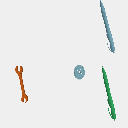

In [ ]:
messy_images[1]

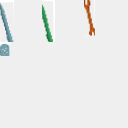

In [ ]:
tidy_image

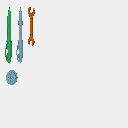

In [ ]:
tidy_images[1]